# Sistem rekomendasi resep makanan
disini kita akan menggunakan content based filtering untuk membuat rekomendasi makanan.

## 1. Importing Libraries

In [1]:
# Library Pengolah Data
import pandas as pd
import numpy as np

# Library System & File
import glob
import os
import pickle  # Untuk menyimpan model
import string  # Untuk membersihkan tanda baca

# Library Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Library Algoritma (Content-Based Filtering)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

print("Libraries berhasil di-import!")

Libraries berhasil di-import!


##2. Load Dataset & Merging
load dataset dan mengabungkan semua datasetnya menjadi satu

In [19]:
# Mencari file CSV
file_paths = glob.glob('*.csv')
print(f"File CSV ditemukan: {len(file_paths)} file")

df_list = []
for file in file_paths:
    try:
        temp_df = pd.read_csv(file)

        # 1. AMBIL KATEGORI DARI NAMA FILE
        # Misal: "dataset-ayam.csv" -> jadi "ayam"
        nama_file = os.path.basename(file)
        kategori = nama_file.replace('dataset-', '').replace('.csv', '')

        # 2. TAMBAHKAN KOLOM KATEGORI
        temp_df['Category'] = kategori

        df_list.append(temp_df)
        print(f" - Berhasil load: {file} (Kategori: {kategori})")

    except Exception as e:
        print(f" - Gagal membaca {file}: {e}")

# 3. GABUNGKAN SEMUA (MERGE)
if df_list:
    df = pd.concat(df_list, ignore_index=True)

    # 4. SIMPAN DATA GABUNGAN (MENTAH)
    # Ini file bukti penggabungan yang Anda tanyakan
    df.to_csv('data_gabungan_mentah.csv', index=False)

    print(f"\n✅ SUKSES! Data digabung & disimpan ke 'data_gabungan_mentah.csv'")
    print(f"Total Data: {len(df)} baris")
    display(df.head())
else:
    print("Error: Tidak ada file CSV.")

File CSV ditemukan: 8 file
 - Berhasil load: dataset-ikan.csv (Kategori: ikan)
 - Berhasil load: dataset-sapi.csv (Kategori: sapi)
 - Berhasil load: dataset-kambing.csv (Kategori: kambing)
 - Berhasil load: dataset-tempe.csv (Kategori: tempe)
 - Berhasil load: dataset-ayam.csv (Kategori: ayam)
 - Berhasil load: dataset-telur.csv (Kategori: telur)
 - Berhasil load: dataset-udang.csv (Kategori: udang)
 - Berhasil load: dataset-tahu.csv (Kategori: tahu)

✅ SUKSES! Data digabung & disimpan ke 'data_gabungan_mentah.csv'
Total Data: 15641 baris


,Title,Ingredients,Steps,Loves,URL,Category
0,Gurame Saus Padang,Bahan utama:--1 ekor gurame--Bumbu untuk saus:...,Cuci bersih ikan gurame yang akan dimasak. Set...,2,/id/resep/4474009-gurame-saus-padang,ikan
1,Ikan Kembung Bakar Teflon,"1/2 kg ikan kembung sate, bersihkan--1 buah je...","Kucuri ikan dengan jeruk, diamkan 5 menit--Lum...",2,/id/resep/4474225-ikan-kembung-bakar-teflon,ikan
2,Mujaer asam pedas manis,1/2 kg ikan mujaer (stok gurame habis)--2 buah...,Bersihkan ikan sampai benar-benar bersih. Kera...,1,/id/resep/4473689-mujaer-asam-pedas-manis,ikan
3,Gurame Asam manis,1/2 kg ikan gurame--2 buah wortel (potong sepe...,Uleg kunir sama garam kasih air lalu guraminya...,5,/id/resep/4473428-gurame-asam-manis,ikan
4,Asam padeh ikan tuna,1/2 kg ikan tuna--6 siung bawang merah--4 siun...,"Haluskan bumbu (cabai merah, kemiri, bawang, k...",7,/id/resep/4473138-asam-padeh-ikan-tuna,ikan


##3. EDA (Exploratory Data Analysis)


In [20]:
print("=== EDA: CEK KONDISI DATA ===")

# 1. Cek Data Kosong
print("\n[1] Data Kosong (NaN) Awal:")
print(df.isnull().sum())

# 2. Cek Duplikat
jumlah_duplikat = df.duplicated(subset=['Title']).sum()
print(f"\n[2] Jumlah Judul Duplikat: {jumlah_duplikat}")

# 3. Cek Data Sampah
sampah = df[df['Title'].astype(str).str.len() < 2]
print(f"\n[3] Data Sampah (< 2 huruf): {len(sampah)}")

=== EDA: CEK KONDISI DATA ===

[1] Data Kosong (NaN) Awal:
Title           0
Ingredients    48
Steps          46
Loves           0
URL             0
Category        0
dtype: int64

[2] Jumlah Judul Duplikat: 3170

[3] Data Sampah (< 2 huruf): 0


##4. Data Preprocessing (Cleaning)
Membersihkan data dan membuang data yang menjadi kosong setelah dibersihkan.

In [21]:
print("=== PREPROCESSING: MEMBERSIHKAN DATA ===")

# 1. Hapus Duplikat
df = df.drop_duplicates(subset=['Title'], keep='first')

# 2. Isi Data Kosong Awal
df['Title'] = df['Title'].fillna('')
df['Ingredients'] = df['Ingredients'].fillna('')
df['Category'] = df['Category'].fillna('') # Isi kategori kosong

# 3. Fungsi Bersih Teks
def text_cleaning(text):
    if isinstance(text, str):
        # Hapus tanda baca & lowercase
        text = "".join([c for c in text if c not in string.punctuation])
        return text.lower().strip()
    return ''

print("-> Membersihkan teks (Title, Ingredients, Category)...")
df['Title_Clean'] = df['Title'].apply(text_cleaning)
df['Ingredients_Clean'] = df['Ingredients'].apply(text_cleaning)
df['Category_Clean'] = df['Category'].apply(text_cleaning)

# 4. HAPUS Data yang jadi Kosong/NaN setelah cleaning
df['Title_Clean'].replace('', np.nan, inplace=True)
df['Ingredients_Clean'].replace('', np.nan, inplace=True)

print(f"-> Data hilang isinya setelah cleaning: {df['Title_Clean'].isnull().sum()}")

# Buang data tersebut
df = df.dropna(subset=['Title_Clean', 'Ingredients_Clean'])
df = df.reset_index(drop=True)

# 5. SIMPAN DATA BERSIH (SIAP PAKAI)
df.to_csv('data_bersih.csv', index=False)
print(f"\n✅ SUKSES! Data bersih disimpan ke 'data_bersih.csv'")
print(f"Total Data Bersih: {len(df)} baris.")

=== PREPROCESSING: MEMBERSIHKAN DATA ===
-> Membersihkan teks (Title, Ingredients, Category)...


/tmp/ipython-input-3724513558.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Title_Clean'].replace('', np.nan, inplace=True)
/tmp/ipython-input-3724513558.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

-> Data hilang isinya setelah cleaning: 0

✅ SUKSES! Data bersih disimpan ke 'data_bersih.csv'
Total Data Bersih: 12468 baris.


##5. Feature Engineering

In [37]:
# --- MODIFIKASI: TITLE BOOSTING ---
def create_combined_features(x):
    # Trik: Kita ulang Title sebanyak 3 kali agar bobotnya lebih besar
    title = (x['Title_Clean'] + ' ') * 3

    # Kita ulang Category 2 kali agar kategori juga penting
    category = (x['Category_Clean'] + ' ') * 2

    # Ingredients cukup 1 kali saja
    ingredients = x['Ingredients_Clean']

    return title + category + ingredients

# Buat kolom fitur gabungan baru
df['combined_features'] = df.apply(create_combined_features, axis=1)

print("Fitur Gabungan dengan Title Boosting berhasil dibuat!")
print(f"Contoh (Title diulang): {df['combined_features'].iloc[0]}")

Fitur Gabungan dengan Title Boosting berhasil dibuat!
Contoh (Title diulang): gurame saus padang gurame saus padang gurame saus padang ikan ikan bahan utama1 ekor guramebumbu untuk saus4 siung bawang putih cincang halus3 siung bawang merah cincang halus15 bh cabai merah giling banyaknya cabai sesuai selera ya😊7 buah cabai rawit iris tipis sesuai selera12 bawang bombang irissaus tiramsaus tomatgaramgulalada1 bh wortel iris tipis memanjang opsional1 buah tomat potong dadu opsional1 batang irisan daun bawang1 ruas jahe ukuran kecil iris tipistepung maizena250 ml airbumbu untuk menggoreng ikan tepung berastepung terigugaramjeruk nipis lemonminyak sayur


##6. Content Based Filtering Model
Melatih model TF-IDF & Cosine Similarity

In [38]:
print("1. Melatih TF-IDF...")
tfidf = TfidfVectorizer(stop_words=None)

# Gunakan kolom 'combined_features'
tfidf_matrix = tfidf.fit_transform(df['combined_features'])
print(f"   Ukuran Matrix: {tfidf_matrix.shape}")

print("2. Menghitung Cosine Similarity...")
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print("Model Selesai!")

1. Melatih TF-IDF...
   Ukuran Matrix: (12468, 34366)
2. Menghitung Cosine Similarity...
Model Selesai!


##7. Testing Model (Tabel Rekomendasi)
Menampilkan tabel rekomendasi resep.

In [39]:
# Mapping Judul ke Index
indices = pd.Series(df.index, index=df['Title_Clean']).drop_duplicates()

def get_recommendations(title_input, cosine_sim=cosine_sim):
    title_clean = text_cleaning(title_input)

    if title_clean not in indices:
        return f"Resep '{title_input}' tidak ditemukan."

    idx = indices[title_clean]
    if isinstance(idx, pd.Series): idx = idx.iloc[0]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11] # Top 10

    recipe_indices = [i[0] for i in sim_scores]

    # Tampilkan Title, Ingredients, dan CATEGORY
    return df[['Title', 'Ingredients', 'Category']].iloc[recipe_indices]

# Tes Tabel
if not df.empty:
    judul_tes = df['Title'].iloc[0]
    print(f"🔍 Rekomendasi untuk: {judul_tes}")
    display(get_recommendations(judul_tes))

🔍 Rekomendasi untuk: Gurame Saus Padang


,Title,Ingredients,Category
687,Gurame goreng tepung saus padang,"1 kg gurame fillet potong kotak, ukuran sesuai...",ikan
1144,Gurame saus padang daun jeruk,1 ekor gurame--Bumbu-bumbu--2 siung bawang put...,ikan
605,Gurame saus tiram,"1 ekor gurame, bersihkan--2 lembar daun jeruk-...",ikan
1587,Gurame saus padang ala bunda ihza,2 ekor gurame sedang (goreng garing)--1 buah j...,ikan
837,Gurame tepung saus tiram,1 ekor gurame ukuran sedang--1 buah bawang bom...,ikan
1130,Gurame pedas asam,2 ekor gurame ukuran besar--1/2 buah bawang bo...,ikan
1650,Gurame asem manis pedas,1 ekor ikan gurame uk sedang--1 bh Jeruk nipis...,ikan
222,Gurame Kecap,5 ekor ikan gurame--2 buah tomat--5 siung bawa...,ikan
932,Gurame Tepung Asam Manis,1 ekor gurame--2 buah jeruk nipis--Secukupnya ...,ikan
226,Gurame panggang teplon bumbu padang*,1 ekor ikan gurame besar (bisa ikan apa saja)-...,ikan


##8. Data Visualization (Similarity Scores)
Visualisasi skor kemiripan.

📊 Grafik Kemiripan untuk: Gurame Saus Padang


/tmp/ipython-input-497966641.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=scores_plot, y=titles_plot, palette='viridis')


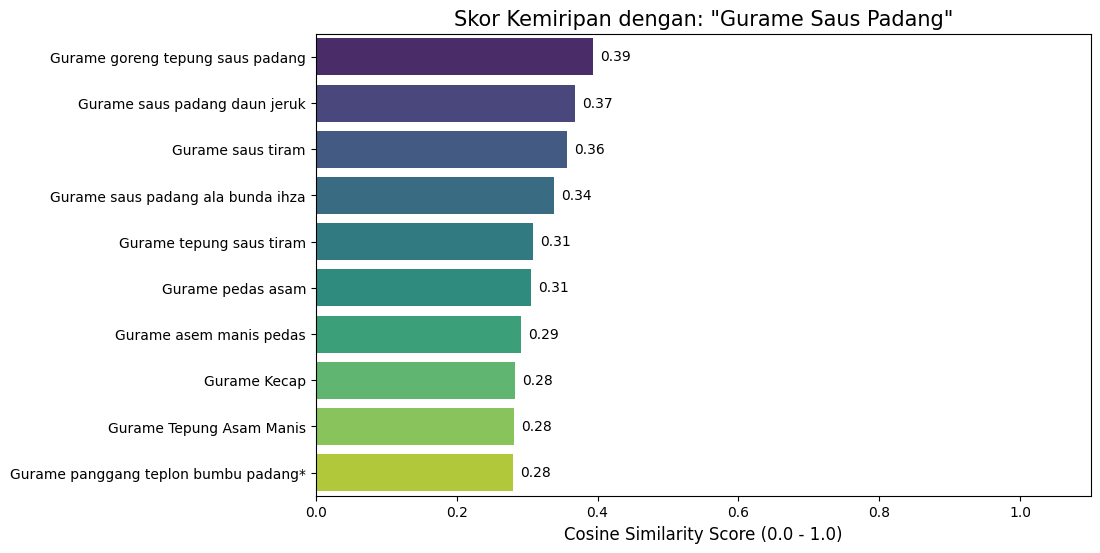

In [40]:
def visualize_similarity(title_input):
    title_clean = text_cleaning(title_input)

    if title_clean not in indices:
        print(f"Resep '{title_input}' tidak ditemukan.")
        return

    idx = indices[title_clean]
    if isinstance(idx, pd.Series): idx = idx.iloc[0]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_10 = sim_scores[1:11]

    indices_plot = [x[0] for x in top_10]
    scores_plot = [x[1] for x in top_10]
    titles_plot = df['Title'].iloc[indices_plot].tolist()

    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(x=scores_plot, y=titles_plot, palette='viridis')

    plt.title(f'Skor Kemiripan dengan: "{title_input}"', fontsize=15)
    plt.xlabel('Cosine Similarity Score (0.0 - 1.0)', fontsize=12)
    plt.xlim(0, 1.1)

    for i, v in enumerate(scores_plot):
        barplot.text(v + 0.01, i, f"{v:.2f}", va='center')

    plt.show()

# Jalankan Visualisasi
if not df.empty:
    judul_tes = df['Title'].iloc[0]
    print(f"📊 Grafik Kemiripan untuk: {judul_tes}")
    visualize_similarity(judul_tes)

##Saving Model

In [42]:
# Buat folder models jika belum ada
if not os.path.exists('models'):
    os.makedirs('models')

print("Sedang menyimpan 4 file model utama...")

# 1. Simpan Data Resep
pickle.dump(df, open('models/recipes.pkl', 'wb'))
print("✅ recipes.pkl tersimpan.")

# 2. Simpan Cosine Similarity
pickle.dump(cosine_sim, open('models/cosine_sim.pkl', 'wb'))
print("✅ cosine_sim.pkl tersimpan.")

# 3. Simpan TF-IDF Vectorizer
# Ini adalah "Kamus" untuk menerjemahkan kata ketikan user
pickle.dump(tfidf, open('models/tfidf_vectorizer.pkl', 'wb'))
print("✅ tfidf_vectorizer.pkl tersimpan.")

# 4. Simpan TF-IDF Matrix
# Ini adalah "Peta" resep dalam bentuk angka
pickle.dump(tfidf_matrix, open('models/tfidf_matrix.pkl', 'wb'))
print("✅ tfidf_matrix.pkl tersimpan.")

print("\nSUKSES! Silakan download ke-4 file tersebut")

Sedang menyimpan 4 file model utama...
✅ recipes.pkl tersimpan.
✅ cosine_sim.pkl tersimpan.
✅ tfidf_vectorizer.pkl tersimpan.
✅ tfidf_matrix.pkl tersimpan.

SUKSES! Silakan download ke-4 file tersebut
